In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, optimizers

In [2]:
# Task 1: Data Exploration and Preprocessing
# 1. Load Data
file_path = 'Alphabets_data.csv'
df = pd.read_csv(file_path)

In [3]:
# EDA
df.head()

,letter,xbox,ybox,width,height,onpix,xbar,ybar,x2bar,y2bar,xybar,x2ybar,xy2bar,xedge,xedgey,yedge,yedgex
0,T,2,8,3,5,1,8,13,0,6,6,10,8,0,8,0,8
1,I,5,12,3,7,2,10,5,5,4,13,3,9,2,8,4,10
2,D,4,11,6,8,6,10,6,2,6,10,3,7,3,7,3,9
3,N,7,11,6,6,3,5,9,4,6,4,4,10,6,10,2,8
4,G,2,1,3,1,1,8,6,6,6,6,5,9,1,7,5,10


In [4]:
df.shape

(20000, 17)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 17 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   letter  20000 non-null  object
 1   xbox    20000 non-null  int64 
 2   ybox    20000 non-null  int64 
 3   width   20000 non-null  int64 
 4   height  20000 non-null  int64 
 5   onpix   20000 non-null  int64 
 6   xbar    20000 non-null  int64 
 7   ybar    20000 non-null  int64 
 8   x2bar   20000 non-null  int64 
 9   y2bar   20000 non-null  int64 
 10  xybar   20000 non-null  int64 
 11  x2ybar  20000 non-null  int64 
 12  xy2bar  20000 non-null  int64 
 13  xedge   20000 non-null  int64 
 14  xedgey  20000 non-null  int64 
 15  yedge   20000 non-null  int64 
 16  yedgex  20000 non-null  int64 
dtypes: int64(16), object(1)
memory usage: 2.6+ MB


In [6]:
df.isnull().sum()

letter    0
xbox      0
ybox      0
width     0
height    0
onpix     0
xbar      0
ybar      0
x2bar     0
y2bar     0
xybar     0
x2ybar    0
xy2bar    0
xedge     0
xedgey    0
yedge     0
yedgex    0
dtype: int64

In [7]:
# 2. Analyze Target Variables
print("\nUnique Classes:", df['letter'].nunique())
print(df['letter'].value_counts().sort_index())


Unique Classes: 26
letter
A    789
B    766
C    736
D    805
E    768
F    775
G    773
H    734
I    755
J    747
K    739
L    761
M    792
N    783
O    753
P    803
Q    783
R    758
S    748
T    796
U    813
V    764
W    752
X    787
Y    786
Z    734
Name: count, dtype: int64


In [8]:
# 3. Preprocessing
# Separate features and target
X = df.drop('letter', axis=1)
y = df['letter']

In [9]:
# Label Encoding for target (A-Z -> 0-25)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [10]:
# Split data into Train and Test (80% Train, 20% Test)
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

In [11]:
# Data Normalization (Standard Scaling)
# ANNs perform much better with normalized input data (mean=0, std=1)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nData preprocessing complete.")
print(f"Training samples: {X_train_scaled.shape[0]}")
print(f"Testing samples: {X_test_scaled.shape[0]}")


Data preprocessing complete.
Training samples: 16000
Testing samples: 4000


In [12]:
# Task 2: Model Implementation (Base Model)

def build_model(hidden_layers=1, neurons=64, learning_rate=0.001):
    model = keras.Sequential()
    model.add(layers.InputLayer(input_shape=(X_train_scaled.shape[1],)))
    
    # Add hidden layers
    for _ in range(hidden_layers):
        model.add(layers.Dense(neurons, activation='relu'))
    
    # Output layer (26 classes for alphabets, softmax activation)
    model.add(layers.Dense(26, activation='softmax'))
    
    # Compile model
    optimizer = optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

print("\n--- Training Base Model ---")
base_model = build_model(hidden_layers=1, neurons=64, learning_rate=0.001)
base_history = base_model.fit(X_train_scaled, y_train, 
                              epochs=50, 
                              batch_size=32, 
                              validation_split=0.2, 
                              verbose=0)

print("Base Model Training Complete.")


--- Training Base Model ---


C:\Users\harsh\anaconda3\envs\data_analysis\lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Base Model Training Complete.


In [13]:
# Task 3: Hyperparameter Tuning
param_grid = {
    'hidden_layers': [1, 2],
    'neurons': [64, 128],
    'learning_rate': [0.01, 0.001]
}

best_acc = 0
best_params = {}
best_model = None

# Loop through all combinations
for hl in param_grid['hidden_layers']:
    for n in param_grid['neurons']:
        for lr in param_grid['learning_rate']:
            print(f"Testing: Layers={hl}, Neurons={n}, LR={lr}")
            
            model = build_model(hidden_layers=hl, neurons=n, learning_rate=lr)
            # Early stopping to prevent overfitting and save time
            callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
            
            history = model.fit(X_train_scaled, y_train, 
                                epochs=30, # Reduced epochs for tuning speed
                                batch_size=32, 
                                validation_split=0.2, 
                                callbacks=[callback],
                                verbose=0)
            
            # Evaluate on validation data (last epoch val_accuracy)
            val_acc = history.history['val_accuracy'][-1]
            print(f"  -> Validation Accuracy: {val_acc:.4f}")
            
            if val_acc > best_acc:
                best_acc = val_acc
                best_params = {'hidden_layers': hl, 'neurons': n, 'learning_rate': lr}
                best_model = model

print(f"\nBest Hyperparameters found: {best_params}")
print(f"Best Validation Accuracy: {best_acc:.4f}")

Testing: Layers=1, Neurons=64, LR=0.01
  -> Validation Accuracy: 0.9075
Testing: Layers=1, Neurons=64, LR=0.001
  -> Validation Accuracy: 0.9178
Testing: Layers=1, Neurons=128, LR=0.01
  -> Validation Accuracy: 0.9262
Testing: Layers=1, Neurons=128, LR=0.001
  -> Validation Accuracy: 0.9400
Testing: Layers=2, Neurons=64, LR=0.01
  -> Validation Accuracy: 0.9156
Testing: Layers=2, Neurons=64, LR=0.001
  -> Validation Accuracy: 0.9362
Testing: Layers=2, Neurons=128, LR=0.01
  -> Validation Accuracy: 0.9212
Testing: Layers=2, Neurons=128, LR=0.001
  -> Validation Accuracy: 0.9553

Best Hyperparameters found: {'hidden_layers': 2, 'neurons': 128, 'learning_rate': 0.001}
Best Validation Accuracy: 0.9553



 Final Evaluation on Test Set
Base Model Results:
Accuracy: 0.9325

Tuned Model Results:
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step
Accuracy: 0.9553

Classification Report:

              precision    recall  f1-score   support

           A       0.98      0.99      0.98       149
           B       0.95      0.93      0.94       153
           C       0.96      0.95      0.95       137
           D       0.93      0.96      0.94       156
           E       0.91      0.99      0.95       141
           F       0.94      0.96      0.95       140
           G       0.99      0.90      0.94       160
           H       0.91      0.89      0.90       144
           I       0.95      0.95      0.95       146
           J       0.97      0.93      0.95       149
           K       0.89      0.91      0.90       130
           L       0.94      0.98      0.96       155
           M       0.99      0.99      0.99       168
           N       0.99      0.95      0.97       151
           O  

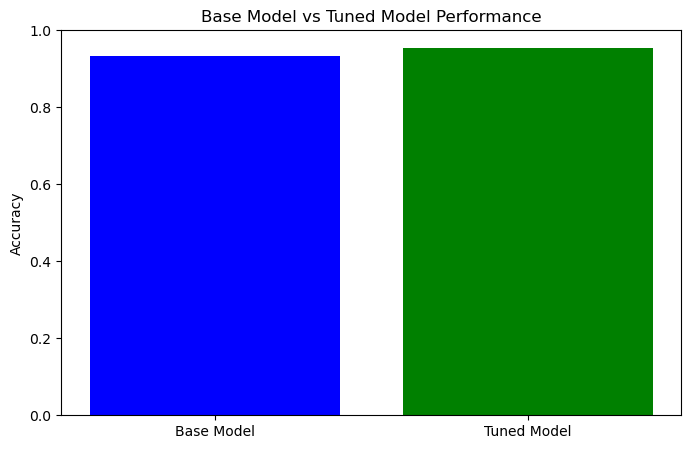

In [14]:
# Task 4: Evaluation
print("\n Final Evaluation on Test Set")

# Evaluate Base Model
print("Base Model Results:")
loss_base, acc_base = base_model.evaluate(X_test_scaled, y_test, verbose=0)
print(f"Accuracy: {acc_base:.4f}")

# Evaluate Best Tuned Model
print("\nTuned Model Results:")
loss_tuned, acc_tuned = best_model.evaluate(X_test_scaled, y_test, verbose=0)
y_pred_probs = best_model.predict(X_test_scaled)
y_pred = np.argmax(y_pred_probs, axis=1)

print(f"Accuracy: {acc_tuned:.4f}")
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Comparison Visual
plt.figure(figsize=(8, 5))
models = ['Base Model', 'Tuned Model']
accuracies = [acc_base, acc_tuned]
plt.bar(models, accuracies, color=['blue', 'green'])
plt.ylim(0, 1.0)
plt.ylabel('Accuracy')
plt.title('Base Model vs Tuned Model Performance')
plt.show()